### Libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

# models
import optuna
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# metric used for the competition
from sklearn.metrics import f1_score

In [115]:
# tf
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import f1_score

### Methods

In [116]:
def transform_column(value):
    if isinstance(value, str):
        if 'one' in value.lower() or 'first' in value.lower() or '1' in value:
            return 1
        elif 'two' in value.lower() or 'second' in value.lower() or '2' in value:
            return 2
        elif 'three' in value.lower() or 'third' in value.lower() or '3' in value or '3.00' in value:
            return 3
        elif 'four' in value.lower() or 'fourth' in value.lower() or '4' in value:
            return 4
        elif 'five' in value.lower() or 'fifth' in value.lower() or '5' in value:
            return 5
        else:
            return value
    else:
        return value
    
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def transform_use(x) :
    if x == 'Private Use' or x == 'Private' or x == 'Prvt' or x == 'Privste' :
        return 'private'
    elif x == 'Public' or x =='Public Space' or x == 'Public Use' :
        return 'public'
    elif x == 'Unknown' or x == 'Unspecified' or x == 'Other' :
        return 'other'
    elif x == 'Institutional Use' or x == 'Institutionals' or x == 'Institutional' :
        return 'institutional'
            
        

### Import Data and Data Overview

In [92]:
path = "..\\Datasets\\train.csv.zip"
data = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")
discrete = ['wall_binding', 'type_of_reinforcement_concrete', 'wall_material']
TARGET = 'damage_grade'
data.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7348\3427009818.py:2: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path,compression="zip", index_col = "Unnamed: 0")


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
4,just 2 floor,22.0,290 ft^2,17.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,Timber Mud or Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


In [93]:
data.shape

(722815, 24)

In [94]:
data.isna().sum()

floors_before_eq (total)          332806
old_building                      239204
plinth_area (ft^2)                421208
height_before_eq (ft)             332806
land_surface_condition            301606
type_of_foundation                239204
type_of_roof                      421208
type_of_ground_floor              332806
type_of_other_floor               301606
position                          312006
building_plan_configuration       301606
technical_solution_proposed       676014
legal_ownership_status            124802
has_secondary_use                 197604
type_of_reinforcement_concrete    291206
residential_type                  270404
no_family_residing                145602
public_place_type                      0
industrial_use_type               114402
govermental_use_type              249604
flexible_superstructure            62400
wall_binding                       62400
wall_material                     228804
damage_grade                           0
dtype: int64

In [95]:
data.duplicated().sum()

335076

In [96]:
data.info() # info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722815 entries, 0 to 37198
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        390009 non-null  object 
 1   old_building                    483611 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           390009 non-null  float64
 4   land_surface_condition          421209 non-null  object 
 5   type_of_foundation              483611 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            390009 non-null  object 
 8   type_of_other_floor             421209 non-null  object 
 9   position                        410809 non-null  object 
 10  building_plan_configuration     421209 non-null  object 
 11  technical_solution_proposed     46801 non-null   object 
 12  legal_ownership_s

In [97]:
data.describe() # numerical description

,old_building,height_before_eq (ft),has_secondary_use,type_of_reinforcement_concrete,wall_binding,wall_material,damage_grade
count,483611.000000,390009.000000,525211.000000,431609.000000,660415.000000,494011.000000,722815.000000
mean,24.342800,16.047158,0.121279,0.072369,4.266729,1.738795,3.643872
std,64.963571,5.527362,0.326451,0.318483,1.667539,0.646120,1.342427
min,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.000000,12.000000,0.000000,0.000000,5.000000,2.000000,3.000000
50%,16.000000,16.000000,0.000000,0.000000,5.000000,2.000000,4.000000
75%,27.000000,18.000000,0.000000,0.000000,5.000000,2.000000,5.000000
max,999.000000,99.000000,1.000000,3.000000,7.000000,3.000000,5.000000


In [98]:
data.describe(include="object")

,floors_before_eq (total),plinth_area (ft^2),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,building_plan_configuration,technical_solution_proposed,legal_ownership_status,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure
count,390009,301607,421209,483611,301607,390009,421209,410809,421209,46801,598013,452411,577213,722815,608413,473211,660415
unique,47,930,3,12,12,15,11,4,10,4,13,6,11,13,9,3,2
top,Floor two,300 ft^2,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,Rectangular,Reconstruction,Private,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable
freq,22000,10937,349097,199916,79640,262305,223114,325721,404366,28847,315103,430854,487302,721495,564106,473073,607527


### Basic Visualizations

d:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='land_surface_condition', ylabel='count'>

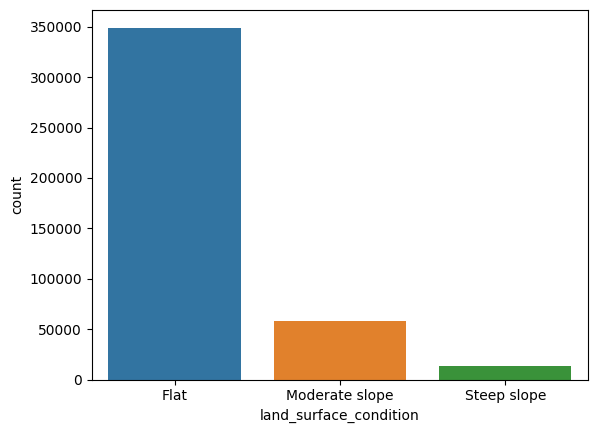

In [99]:
sns.countplot(data['land_surface_condition'])

d:\Programs\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='damage_grade', ylabel='count'>

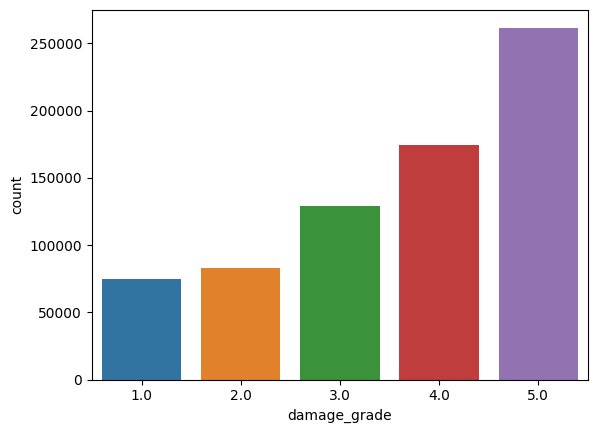

In [100]:
sns.countplot(data['damage_grade'])

### Preprocessing

In [101]:
data['public_place_type'] = data['public_place_type'].apply(lambda x : 'Public' if x != 'Non-public' else x)
data['technical_solution_proposed'] = data['technical_solution_proposed'].fillna(data.groupby(['public_place_type', 'damage_grade'])['technical_solution_proposed'].transform(lambda x: x.mode().values[0] if not x.mode().empty else None))

In [102]:
data2 = data.dropna(axis=0).reset_index(drop=True)

In [103]:
data2.shape

(301607, 24)

### Univariate Analysis

In [104]:
# sns.countplot(x=data2['public_place_type'], hue=data2['damage_grade'])

In [105]:
# data2['public_place_type'].value_counts()

### Method 1 : Dropping all NaN values

In [106]:
# data2['no_family_residing'] = data2['no_family_residing'].apply(lambda x: 0 if x == 'None' else int(float(x)))

data2[discrete] = data2[discrete].astype(str)
data2['legal_ownership_status'] = data2['legal_ownership_status'].apply(lambda x : transform_use(x))

data2['floors_before_eq (total)'] = data2['floors_before_eq (total)'].apply(lambda x: transform_column(x))
data2['floors_before_eq (total)'] = pd.to_numeric(data2['floors_before_eq (total)'])

data2['plinth_area (ft^2)'] = data2['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
data2['plinth_area (ft^2)'] = pd.to_numeric(data2['plinth_area (ft^2)'])

data2['type_of_ground_floor'] = data2['type_of_ground_floor'].str.lower()

data2['volume'] = data2['plinth_area (ft^2)'] * data2['height_before_eq (ft)']
data2['heightPerFloor'] = data2['height_before_eq (ft)'] / data2['floors_before_eq (total)']

data2.drop(['no_family_residing', 'legal_ownership_status', 'govermental_use_type', 'industrial_use_type'], axis=1, inplace=True)

# data2 = data2.drop('technical_solution_proposed', axis=1)


In [107]:
# data_num = data2.select_dtypes(include='number').drop(TARGET, axis=1)
# data_num = data_num.select_dtypes(include='number').drop(discrete, axis=1)
# scaler = MinMaxScaler()
# scaled = pd.concat([data2[discrete], pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns, index=data_num.index)], axis=1)

# data_cat = data2.select_dtypes('object')
# encoder = OneHotEncoder(drop='first')
# concat = pd.concat([scaled, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns)), data2[TARGET]], axis=1)
# concat
# scaler1 = RobustScaler()
# scaler2 = StandardScaler()
scaler3 = MinMaxScaler()
data_num = data2.select_dtypes(include='number').drop(TARGET, axis=1)
# data_num['old_building'] = scaler1.fit_transform(data_num['old_building'].to_numpy().reshape(-1,1))
# data_num['old_building'] = scaler2.fit_transform(data_num['old_building'].to_numpy().reshape(-1,1))
data_num['old_building'] = scaler3.fit_transform(data_num['old_building'].to_numpy().reshape(-1,1))
    


data_cat = data2.select_dtypes('object')
encoder = OneHotEncoder(drop='first')
concat = pd.concat([data_num, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns)), data2[TARGET]], axis=1)

# threshold = VarianceThreshold(threshold=0.01)
# transformed = threshold.fit_transform(concat)
# concat = pd.DataFrame(data=transformed, columns=concat.columns[threshold.get_support()])
# concat = pd.concat([concat, data2[TARGET]], axis=1)

d:\Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
concat

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),has_secondary_use,volume,heightPerFloor,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,type_of_foundation_Bamboo/TImber,...,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1.0,wall_material_2.0,wall_material_3.0,damage_grade
0,2,0.001001,256,22.0,0.0,5632.0,11.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,0.003003,985,18.0,0.0,17730.0,6.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0
2,2,0.018018,185,15.0,0.0,2775.0,7.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0
3,2,0.022022,290,17.0,0.0,4930.0,8.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,2,0.040040,504,14.0,0.0,7056.0,7.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301602,1,0.030030,276,9.0,0.0,2484.0,9.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0
301603,2,0.008008,432,14.0,0.0,6048.0,7.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
301604,2,0.026026,392,19.0,1.0,7448.0,9.5,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0
301605,2,0.017017,300,16.0,0.0,4800.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0


### Training

In [109]:
X = concat.drop(TARGET, axis=1)
y = concat[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
# score = cross_val_score(estimator=RandomForestClassifier(),X=X, y=y, scoring='f1_macro', cv=skf)
# score


In [110]:
# # random forest with optuna
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# result = model.predict(X_test)
# score = f1_score(y_test, result, average='macro')
# score

def objective(trial):
      n_estimators = trial.suggest_int('n_estimators', 2, 20)
      max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))
      clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
      return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3, scoring='f1_macro').mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # xgboost
# model = XGBClassifier()
# model.fit(X_train, y_train)
# result = model.predict(X_test)
# score = f1_score(y_test, result, average='macro')
# score

# Catboost wit gs
# parameters = {'depth'         : [4,5,6,7,8,9, 10],
#               'learning_rate' : [0.01,0.02,0.03,0.04],
#               'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
#                  }
# model = CatBoostClassifier(depth=10, iterations=200, learning_rate=0.4)
# model.fit(X_train, y_train)
# result = model.predict(X_test)
# score = f1_score(y_test, result, average='macro')
# score

# Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, scoring='f1_macro')
# Grid_CBC.fit(X_train, y_train)
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [111]:
# trial = study.best_trial
# print('Accuracy: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

In [ ]:
score = []
max_depth = list(range(40-100))

for i in range(10):
        model = RandomForestClassifier(n_estimators=100, max_depth=i)
        model.fit(X_train, y_train)
        result = model.predict(X_test)
        score = f1_score(y_test, result, average='macro')
        sc_i.append(accuracy_score(y_test[i], adaline_prediction[i][j]))
  adaline_accuracy.append(acc_i)

In [ ]:
pd.DataFrame(adaline_accuracy, columns=['max_epoch {index}'.format(index= i) for i in range(100, 1001, 100)])

In [112]:
model = RandomForestClassifier(n_estimators=100, max_depth=41)
model.fit(X_train, y_train)
result = model.predict(X_test)
score = f1_score(y_test, result, average='macro')
score

0.8040810895281304

### Grid Search BbyGurl;)

In [ ]:
forest_params = [{'max_depth': list(range(10, 12)), 'max_features': list(range(50,98, 16))}]
clf = GridSearchCV(RandomForestClassifier(), forest_params, cv=5, scoring='f1_macro')
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

### Capping the outliers

In [42]:
data2[data2['old_building'] < 800].max()

floors_before_eq (total)                                  two story
old_building                                                  200.0
plinth_area (ft^2)                              More than 1000 ft^2
height_before_eq (ft)                                          99.0
land_surface_condition                                  Steep slope
type_of_foundation                              Reinforced Concrete
type_of_roof                      reinforced cement concrete/rb/rbc
type_of_ground_floor                        soil, water, loam Mixed
type_of_other_floor               reinforced cement concrete/rb/rbc
position                                               Not attached
building_plan_configuration                                 U-shape
technical_solution_proposed                          Reconstruction
legal_ownership_status                                  Unspecified
has_secondary_use                                               1.0
type_of_reinforcement_concrete                  

### Test Data

In [65]:
test_path = "..\\Datasets\\test.csv.zip"
test = pd.read_csv(test_path,compression="zip", index_col='id')
test['wall_binding'] = test['wall_binding'].apply(lambda x: str(float(x)))
test['type_of_reinforcement_concrete'] = test['type_of_reinforcement_concrete'].apply(lambda x: str(float(x)))
test['wall_material'] = test['wall_material'].apply(lambda x: str(float(x)))
# test = test.drop(['height_before_eq (ft)', 'wall_binding'], axis=1)
test.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,has_secondary_use,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material
id,,,,,,,,,,,,,,,,,,,,,
0,2,7,418 ft^2,14,Flat,Clay mortar-Stone/Brick,Bamboo/TImber-Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
1,3.00,13,396 ft^2,21,Flat,Clay mortar-Stone/Brick,Bamboo/TImber-Heavy Roof,Brick or Stone,TImber/Bamboo-Mud,Not attached,...,0.0,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
2,Floor-three,40,400 ft^2,18,Flat,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,Wood or Bamboo Mud,Not attached,...,0.0,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
3,floor second,25,378 ft^2,20,Flat,Bamboo or Timber,Bamboo/Timber Heavy roof,mud,TImber/Bamboo-Mud,Attached-2 side,...,0.0,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0
4,just 2 floor,5,375 ft^2,20,Flat,Mud mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,Wood-Mud or Bamboo Mud,Attached-1 side,...,0.0,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0


In [66]:
test.shape

(242082, 23)

In [68]:
test['public_place_type'].value_counts()

Non-public                      241662
Shopping Sites                      93
Religious Sites                     63
Hospital                            54
Middle School                       43
Primary School                      42
Drugstore                           31
University                          21
High School                         18
Museum                              18
Other Institutional Building        16
Health Clinics                      12
Recreational Park                    9
Name: public_place_type, dtype: int64

<AxesSubplot:xlabel='public_place_type', ylabel='count'>

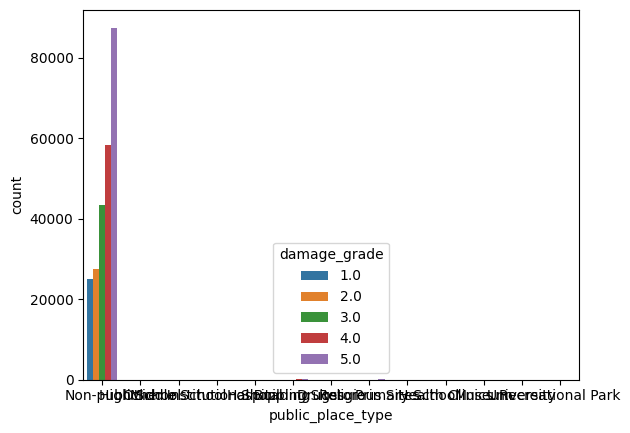

In [67]:
sns.countplot(x=test['public_place_type'], hue=data2['damage_grade'])

In [24]:
# data2['no_family_residing'] = data2['no_family_residing'].apply(lambda x: 0 if x == 'None' else int(float(x)))

test[discrete] = test[discrete].astype(str)
test['legal_ownership_status'] = test['legal_ownership_status'].apply(lambda x : transform_use(x))

test['floors_before_eq (total)'] = test['floors_before_eq (total)'].apply(lambda x: transform_column(x))
test['floors_before_eq (total)'] = pd.to_numeric(test['floors_before_eq (total)'])

test['plinth_area (ft^2)'] = test['plinth_area (ft^2)'].apply(lambda x : x.split(" ")[0] if x != "More than 1000 ft^2" else x.split(" ")[-2])
test['plinth_area (ft^2)'] = pd.to_numeric(test['plinth_area (ft^2)'])

test['type_of_ground_floor'] = test['type_of_ground_floor'].str.lower()

test['volume'] = test['plinth_area (ft^2)'] * test['height_before_eq (ft)']
test['heightPerFloor'] = test['height_before_eq (ft)'] / test['floors_before_eq (total)']

test.drop(['no_family_residing', 'legal_ownership_status', 'govermental_use_type', 'industrial_use_type'], axis=1, inplace=True)

# data2 = data2.drop('technical_solution_proposed', axis=1)


In [25]:
# data_num = data2.select_dtypes(include='number').drop(TARGET, axis=1)
# data_num = data_num.select_dtypes(include='number').drop(discrete, axis=1)
# scaler = MinMaxScaler()
# scaled = pd.concat([data2[discrete], pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns, index=data_num.index)], axis=1)

# data_cat = data2.select_dtypes('object')
# encoder = OneHotEncoder(drop='first')
# concat = pd.concat([scaled, pd.DataFrame(encoder.fit_transform(data_cat).toarray(), columns=encoder.get_feature_names(data_cat.columns)), data2[TARGET]], axis=1)
# concat
# scaler1 = RobustScaler()
# scaler2 = StandardScaler()
# scaler3 = MinMaxScaler()
test_num = test.select_dtypes(include='number')
# test_num['old_building'] = scaler1.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
# test_num['old_building'] = scaler2.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
test_num['old_building'] = scaler3.fit_transform(test_num['old_building'].to_numpy().reshape(-1,1))
    


test_cat = test.select_dtypes('object')
# encoder = OneHotEncoder(drop='first')
test_concat = pd.concat([test_num, pd.DataFrame(encoder.fit_transform(test_cat).toarray(), columns=encoder.get_feature_names(test_cat.columns))], axis=1)
test_concat
# threshold = VarianceThreshold(threshold=0.01)
# transformed = threshold.fit_transform(concat)
# concat = pd.DataFrame(data=transformed, columns=concat.columns[threshold.get_support()])
# concat = pd.concat([concat, data2[TARGET]], axis=1)

d:\Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),has_secondary_use,volume,heightPerFloor,land_surface_condition_Moderate slope,land_surface_condition_Steep slope,type_of_foundation_Bamboo/TImber,...,public_place_type_University,flexible_superstructure_unavailable,wall_binding_1.0,wall_binding_2.0,wall_binding_3.0,wall_binding_5.0,wall_binding_7.0,wall_material_1.0,wall_material_2.0,wall_material_3.0
0,2,0.007007,418,14,0.0,5852,7.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3,0.013013,396,21,0.0,8316,7.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3,0.040040,400,18,0.0,7200,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2,0.025025,378,20,0.0,7560,10.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2,0.005005,375,20,0.0,7500,10.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242077,2,0.015015,240,15,0.0,3600,7.5,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242078,3,0.004004,174,18,0.0,3132,6.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242079,2,0.014014,375,14,0.0,5250,7.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242080,2,0.009009,486,16,0.0,7776,8.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [26]:
test_result = model.predict(test_concat)

In [27]:
final_result = pd.DataFrame(test_result)

In [28]:
final_result = final_result.rename(columns={0 : 'damage_grade'})
final_result.insert(0, 'id', final_result.index)
final_result = final_result.set_index('id')
final_result['damage_grade'] = final_result['damage_grade'].astype('int')

In [29]:
final_result

,damage_grade
id,
0,5
1,5
2,5
3,5
4,2
...,...
242077,3
242078,5
242079,1


In [30]:
final_result.to_csv('result_technical_diimput_mode.csv')